In [1]:
%load_ext autoreload
%autoreload 2

from vqr.data import generate_linear_x_y_mvn_data
from vqr.api import VectorQuantileRegressor
from vqr.vqr import RVQRDualLSESolver
from numpy.random import uniform, randint

In [3]:
d = 2
k = 2
n = 5000
X, Y_orig = generate_linear_x_y_mvn_data(n=n, d=d, k=k)

T = 50
epsilon = 1e-5
vqr_ = VectorQuantileRegressor(
    n_levels=T,
    solver=RVQRDualLSESolver(
        verbose=True, num_epochs=1500, epsilon=epsilon, learning_rate=0.9
    ),
)
U_samples = randint(0, T, size=(n, 2))

vqr_ = vqr_.fit(X, Y_orig)

A = vqr_._fitted_solution._A
B = vqr_._fitted_solution._B

epoch_idx=0, total_loss=2.183848 constraint_loss=2.083852, elapsed=0.24s
epoch_idx=100, total_loss=0.721974 constraint_loss=0.621972, elapsed=19.79s
epoch_idx=200, total_loss=0.582445 constraint_loss=0.482446, elapsed=19.45s
epoch_idx=300, total_loss=0.542645 constraint_loss=0.442645, elapsed=20.64s
Epoch 00338: reducing learning rate of group 0 to 4.5000e-01.
epoch_idx=400, total_loss=0.531920 constraint_loss=0.431920, elapsed=20.82s
Epoch 00452: reducing learning rate of group 0 to 2.2500e-01.
epoch_idx=500, total_loss=0.529121 constraint_loss=0.429121, elapsed=19.95s
Epoch 00553: reducing learning rate of group 0 to 1.1250e-01.
epoch_idx=600, total_loss=0.528134 constraint_loss=0.428134, elapsed=19.93s
Epoch 00654: reducing learning rate of group 0 to 5.6250e-02.
epoch_idx=700, total_loss=0.527715 constraint_loss=0.427715, elapsed=19.46s
Epoch 00755: reducing learning rate of group 0 to 2.8125e-02.
epoch_idx=800, total_loss=0.527532 constraint_loss=0.427532, elapsed=19.55s
Epoch 008

In [4]:
from vqr.vqr import decode_quantile_values
from numpy import zeros, array

# Sample X, Uniformly sample U to get Y

X_new = uniform(size=[n, k]) - 0.5
Y_samp = zeros([n, d])

for i in range(X.shape[0]):
    Y_hat = (B @ X_new[i, :][:, None]) + A
    Q1, Q2 = decode_quantile_values(T, d=2, Y_hat=Y_hat)
    u1, u2 = randint(0, T), randint(0, T)
    Y_samp[i, :] = array((Q1[u1, u2], Q2[u1, u2]))

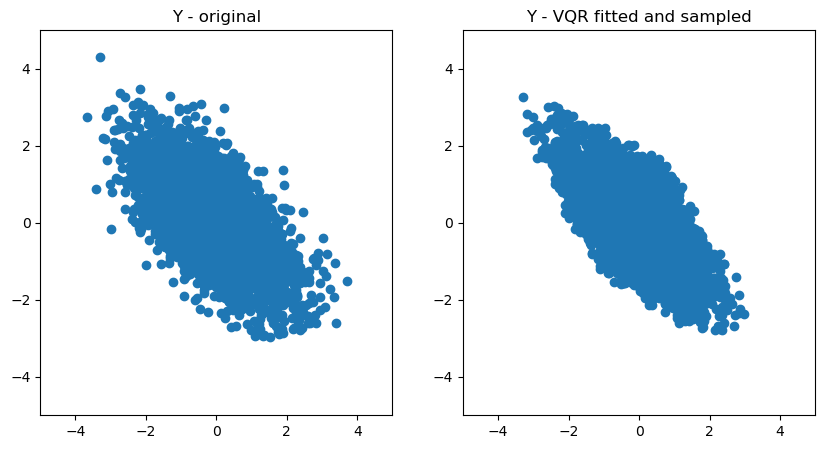

In [5]:
import matplotlib.pyplot as plt

def w2(Y_gt_, Y_est_):
    return ot.emd2(
        a=[],
        b=[],
        M=ot.dist(Y_gt_, Y_est_),
        numItermax=200_000,
        numThreads=4
    )


fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(Y_orig[:, 0], Y_orig[:, 1])
ax[0].set_title("Y - original")
ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-5, 5)

ax[1].scatter(Y_samp[:, 0], Y_samp[:, 1])
ax[1].set_title("Y - VQR fitted and sampled")
ax[1].set_xlim(-5, 5)
ax[1].set_ylim(-5, 5)

plt.show()

In [14]:
# Generate a quantile function that is nonlinear in X

def g(x):
    # A nonlinear function in X
    Q = array([[10.0, 1.0], [1.0, 2.0]])
    return x.T @ Q @ x + x


Y_nl = zeros([n, d])
for i in range(n):
    # Sample using a known B but the quantile function is now nonlinear in X
    Y_hat = (B @ g(X_new[i, :][:, None])) + A
    Q1, Q2 = decode_quantile_values(T, d=2, Y_hat=Y_hat)
    u1, u2 = randint(0, T), randint(0, T)
    Y_nl[i, :] = array((Q1[u1, u2], Q2[u1, u2]))

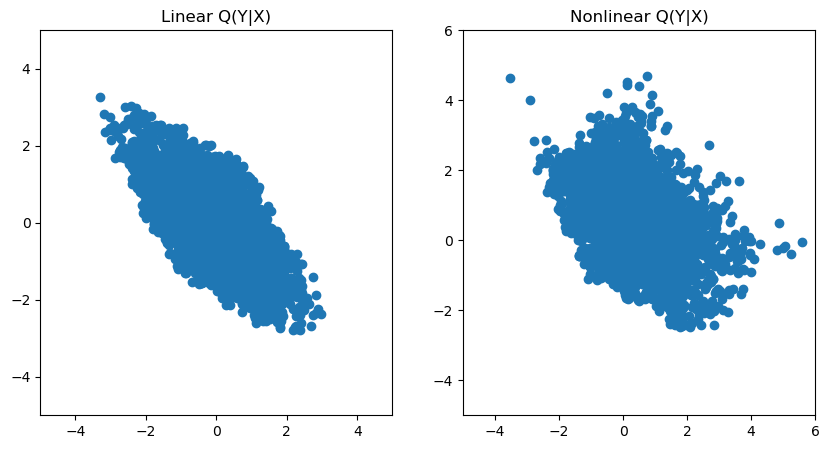

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(Y_samp[:, 0], Y_samp[:, 1])
ax[0].set_title("Linear Q(Y|X)")
ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-5, 5)

ax[1].scatter(Y_nl[:, 0], Y_nl[:, 1])
ax[1].set_title("Nonlinear Q(Y|X)")
ax[1].set_xlim(-5, 6)
ax[1].set_ylim(-5, 6)

plt.show()

In [22]:
# We know that the distribution on the right has a nonlinear quantile function w.r.to X. 
# Now we fit a VQR on this data to get a linear approximation of this nonlinear function.
# This allows us to measure how mis-specified is the quantile function

vqr_approximating_nl = VectorQuantileRegressor(
    solver_opts={"verbose": True, "num_epochs": 1000, "epsilon": 0.00001}
)
vqr_approximating_nl = vqr_approximating_nl.fit(X_new, Y_nl)
B_approximating_nl = vqr_approximating_nl._fitted_solution._B
A_approximating_nl = vqr_approximating_nl._fitted_solution._A


epoch_idx=0, total_loss=3.596548 constraint_loss=3.496552, elapsed=0.33s
epoch_idx=100, total_loss=1.313253 constraint_loss=1.213251, elapsed=21.34s
epoch_idx=200, total_loss=1.092346 constraint_loss=0.992347, elapsed=21.40s
epoch_idx=300, total_loss=1.019047 constraint_loss=0.919047, elapsed=21.77s
epoch_idx=400, total_loss=0.992173 constraint_loss=0.892173, elapsed=21.48s
Epoch 00418: reducing learning rate of group 0 to 4.5000e-01.
epoch_idx=500, total_loss=0.985489 constraint_loss=0.885489, elapsed=21.78s
Epoch 00519: reducing learning rate of group 0 to 2.2500e-01.
epoch_idx=600, total_loss=0.983850 constraint_loss=0.883850, elapsed=21.81s
Epoch 00620: reducing learning rate of group 0 to 1.1250e-01.
epoch_idx=700, total_loss=0.983269 constraint_loss=0.883269, elapsed=21.45s
Epoch 00721: reducing learning rate of group 0 to 5.6250e-02.
epoch_idx=800, total_loss=0.983030 constraint_loss=0.883030, elapsed=20.86s
Epoch 00822: reducing learning rate of group 0 to 2.8125e-02.
epoch_idx

In [23]:
Y_approximated_nl = zeros([n, d])
for i in range(n):
    # Y_hat = (B_approximating_nl @ g(X_new[i, :][:, None])) + A_approximating_nl
    Y_hat = (B_approximating_nl @ X_new[i, :][:, None]) + A_approximating_nl
    Q1, Q2 = decode_quantile_values(T, d=2, Y_hat=Y_hat)
    u1, u2 = randint(0, T), randint(0, T)
    Y_approximated_nl[i, :] = array((Q1[u1, u2], Q2[u1, u2]))

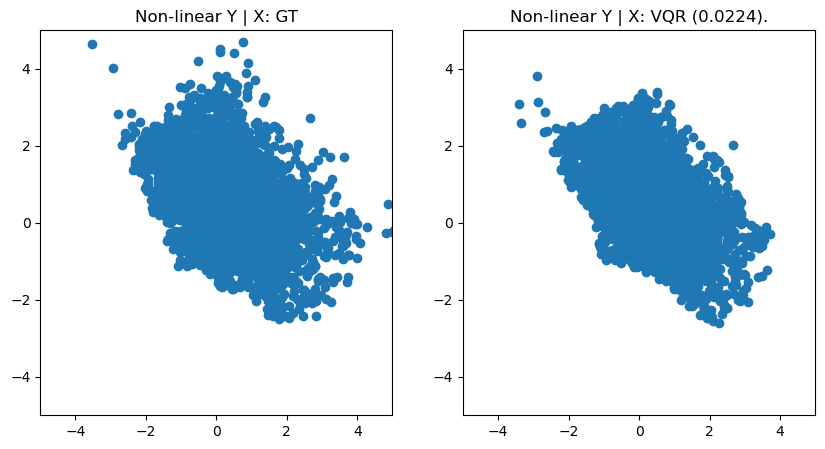

In [32]:
import ot
def w2(Y_gt_, Y_est_):
    return ot.emd2(
        a=[],
        b=[],
        M=ot.dist(Y_gt_, Y_est_),
        numItermax=200_000,
        numThreads=4
    )

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(Y_nl[:, 0], Y_nl[:, 1])
ax[0].set_title("Non-linear Y | X: GT")
ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-5, 5)

ax[1].scatter(Y_approximated_nl[:, 0], Y_approximated_nl[:, 1])
ax[1].set_title(f"Non-linear Y | X: VQR ({w2(Y_nl, Y_approximated_nl):.4f}).")
ax[1].set_xlim(-5, 5)
ax[1].set_ylim(-5, 5)

plt.show()

In [26]:
from numpy import stack

nonlinear_vqr_gt = VectorQuantileRegressor(solver_opts={"verbose": True, "num_epochs": 1000, "epsilon": 0.00001})
nonlinear_vqr_gt = nonlinear_vqr_gt.fit(
    stack([g(X_new[i, :]) for i in range(n)]), Y_nl
)
B_nl_gt = nonlinear_vqr_gt._fitted_solution._B
A_nl_gt = nonlinear_vqr_gt._fitted_solution._A


epoch_idx=0, total_loss=3.596548 constraint_loss=3.496552, elapsed=0.22s
epoch_idx=100, total_loss=0.558982 constraint_loss=0.458980, elapsed=21.02s
epoch_idx=200, total_loss=0.210358 constraint_loss=0.110358, elapsed=21.32s
epoch_idx=300, total_loss=-0.035448 constraint_loss=-0.135446, elapsed=20.45s
epoch_idx=400, total_loss=-0.266473 constraint_loss=-0.366472, elapsed=20.45s
epoch_idx=500, total_loss=-0.494624 constraint_loss=-0.594626, elapsed=20.46s
epoch_idx=600, total_loss=-0.721926 constraint_loss=-0.821927, elapsed=20.61s
epoch_idx=700, total_loss=-0.948687 constraint_loss=-1.048688, elapsed=20.54s
epoch_idx=800, total_loss=-1.174988 constraint_loss=-1.274990, elapsed=20.98s
epoch_idx=900, total_loss=-1.401177 constraint_loss=-1.501182, elapsed=21.33s
epoch_idx=999, total_loss=-1.624977 constraint_loss=-1.724982, elapsed=20.94s
total_time=208.30s


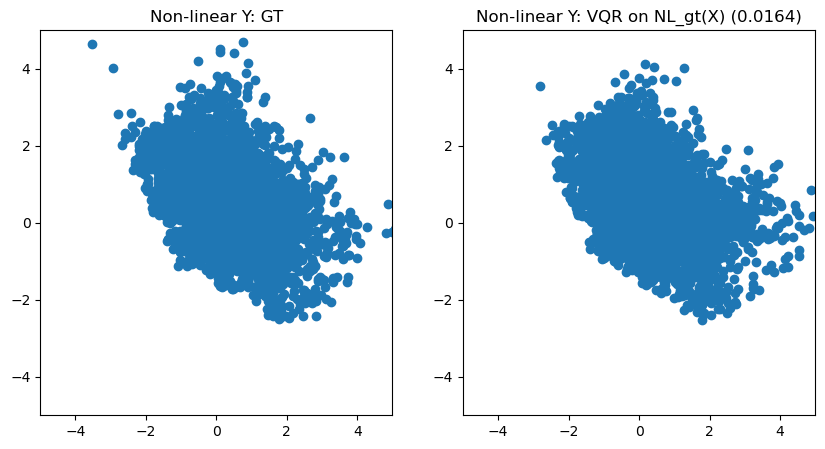

In [34]:
import ot
def w2(Y_gt_, Y_est_):
    return ot.emd2(
        a=[],
        b=[],
        M=ot.dist(Y_gt_, Y_est_),
        numItermax=200_000,
        numThreads=4
    )

Y_nl_gt = zeros([n, d])
for i in range(n):
    Y_hat = (B_nl_gt @ g(X_new[i, :][:, None])) + A_nl_gt
    Q1, Q2 = decode_quantile_values(T, d=2, Y_hat=Y_hat)
    u1, u2 = randint(0, T), randint(0, T)
    Y_nl_gt[i, :] = array((Q1[u1, u2], Q2[u1, u2]))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(Y_nl[:, 0], Y_nl[:, 1])
ax[0].set_title("Non-linear Y: GT")
ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-5, 5)

ax[1].scatter(Y_nl_gt[:, 0], Y_nl_gt[:, 1])
ax[1].set_title(f"Non-linear Y: VQR on NL_gt(X) ({w2(Y_nl, Y_nl_gt):.4f})")
ax[1].set_xlim(-5, 5)
ax[1].set_ylim(-5, 5)

plt.show()

In [21]:
from vqr.vqr import NonlinearRVQRDualLSESolver
import pickle

with open("nonlin-y.pkl", "wb") as f:
    pickle.dump({'X': X_new, 'Y': Y_nl}, f)